In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantecon import LQ
import seaborn as sns
from matplotlib.gridspec import GridSpec
from config import benchmark_dict_opt, result_path

result_dir = os.path.join(result_path, 'optimal_model')
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

No GPU devices detected. Setting JAX to use CPU only.


In [2]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [3]:
beta = benchmark_dict_opt['beta']
sigma = benchmark_dict_opt['sigma']
kappa = benchmark_dict_opt['kappa']
rho_r = benchmark_dict_opt['rho_r']
rho_u = benchmark_dict_opt['rho_u']
sigma_r = benchmark_dict_opt['sigma_r']
sigma_u = benchmark_dict_opt['sigma_u']
lambda_x = benchmark_dict_opt['lambda_x']
lambda_i = benchmark_dict_opt['lambda_i']
x_star = 0.0
i_star = (1/beta) - 1

### Q1

In [4]:
A = np.array([
    [1, 0, 0, 0, 0],
    [-kappa/beta, 1/beta, -kappa/beta, -1/beta, 0],
    [sigma*(kappa/beta + 1), -sigma/beta, sigma*beta+1, sigma/beta, -sigma],
    [0, 0, 0, rho_u, 0],
    [0, 0, 0, 0, rho_r]
])

B = np.array([
    [0],
    [0],
    [sigma],
    [0],
    [0]
])

# Define LQ problem weight matrices
Q = np.array([[lambda_i]])
R = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, lambda_x, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
])

# Initialize LQ problem and solve
lq = LQ(Q, R, A, B, beta=beta)
P, F, d = lq.stationary_values()

# Print F matrix and verify F4, F5 values
print(f"F matrix (optimal feedback rule):\n{F}")
print(f"\nVerify F4 and F5 are approximately zero:")
print(f"F4 ≈ 0: {np.abs(F[0, 3]) < 1e-10}")
print(f"F5 ≈ 0: {np.abs(F[0, 4]) < 1e-10}")

# Calculate Taylor rule coefficients
phi_pi = -F[0, 1]
phi_x = -F[0, 2]
phi_0 = -F[0, 0] + F[0, 2] * x_star + i_star

# Print optimal Taylor rule coefficients
print(f"\nOptimal Taylor rule: i_t = {phi_pi:.4f}*π_t + {phi_x:.4f}*x_t + {phi_0:.4f}")

F matrix (optimal feedback rule):
[[ 2.28317256 -3.11539053  2.2376021   4.52954715 -0.4352364 ]]

Verify F4 and F5 are approximately zero:
F4 ≈ 0: False
F5 ≈ 0: False

Optimal Taylor rule: i_t = 3.1154*π_t + -2.2376*x_t + -2.2731


### Q2

In [5]:
def simulate_irf(A, B, F, shock_type, shock_size=1.0, periods=100):
    # Initialize state vector and storage
    n_states = A.shape[0]
    state = np.zeros(n_states)
    # Set initial shock
    if shock_type == 'demand':
        state[4] = shock_size  # Demand shock r^n
    elif shock_type == 'cost_push':
        state[3] = shock_size  # Cost-push shock u
    # Arrays to store results
    states_history = np.zeros((periods, n_states))
    interest_rates = np.zeros(periods)
    # Simulate dynamic system
    for t in range(periods):
        states_history[t] = state
        # Calculate optimal interest rate (i_t = -F·s_t)
        interest_rates[t] = -F @ state
        # Update state (s_{t+1} = A·s_t + B·i_t)
        state = A @ state + B @ (-F @ state)
    # Extract results
    inflation = states_history[:, 1]       # π_t
    output_gap = states_history[:, 2]      # x_t

    return pd.DataFrame({
        'inflation': inflation,
        'output_gap': output_gap,
        'interest_rate': interest_rates,
        'time': np.arange(periods)
    })

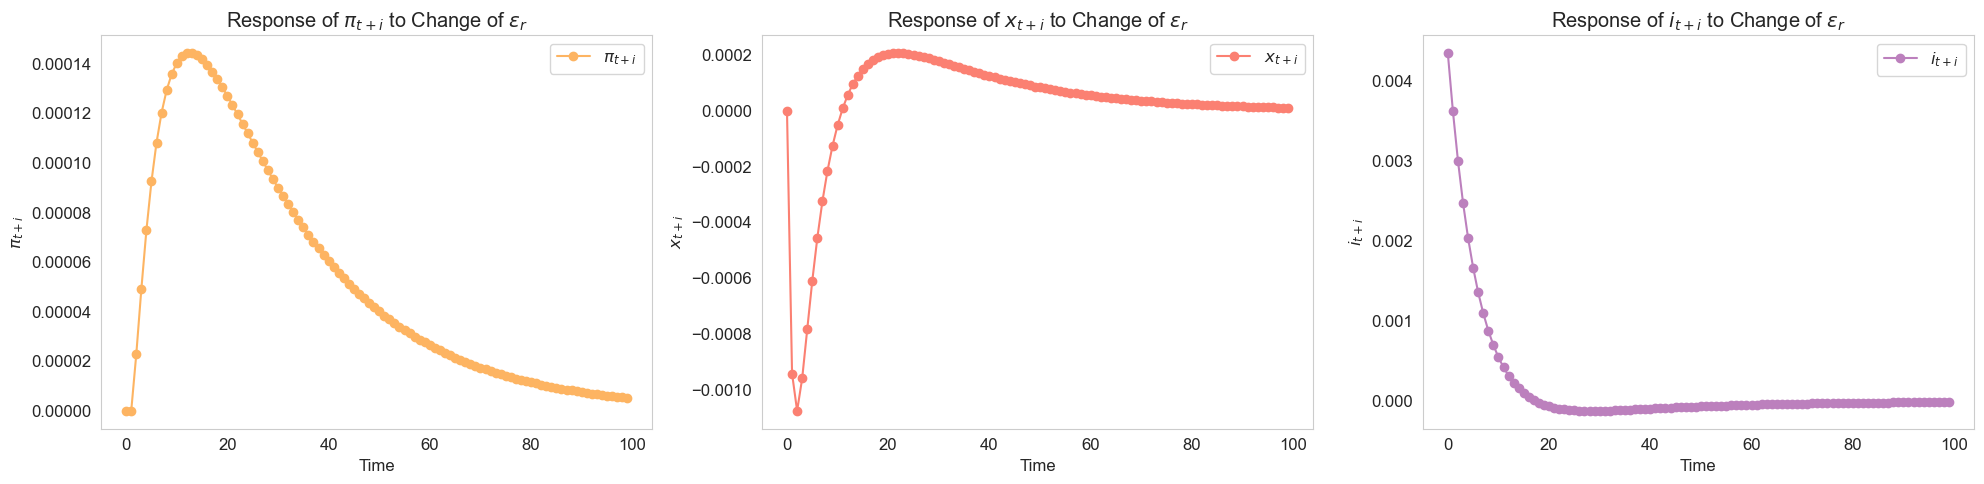

In [6]:
demand_irf = simulate_irf(A, B, F, 'demand', shock_size=0.01)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
labels = [r'$\pi_{t+i}$', r'$x_{t+i}$', r'$i_{t+i}$']
shocks_name = r'$ε_{r}$'

color_name = 'Set3' 
select1 = (0.45,0.3,0.8)
colors_1 = plt.get_cmap(color_name)(select1)

for i in range(3):
    axes[i].plot(range(len(demand_irf)), demand_irf.iloc[:, i], marker='o', linestyle='-', color=colors_1[i], label=labels[i])
    axes[i].set_title(f'Response of {labels[i]} to Change of {shocks_name}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(labels[i])
    axes[i].grid()
    axes[i].legend(loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(result_dir, f'response_demand.png'), dpi=300)
plt.show()

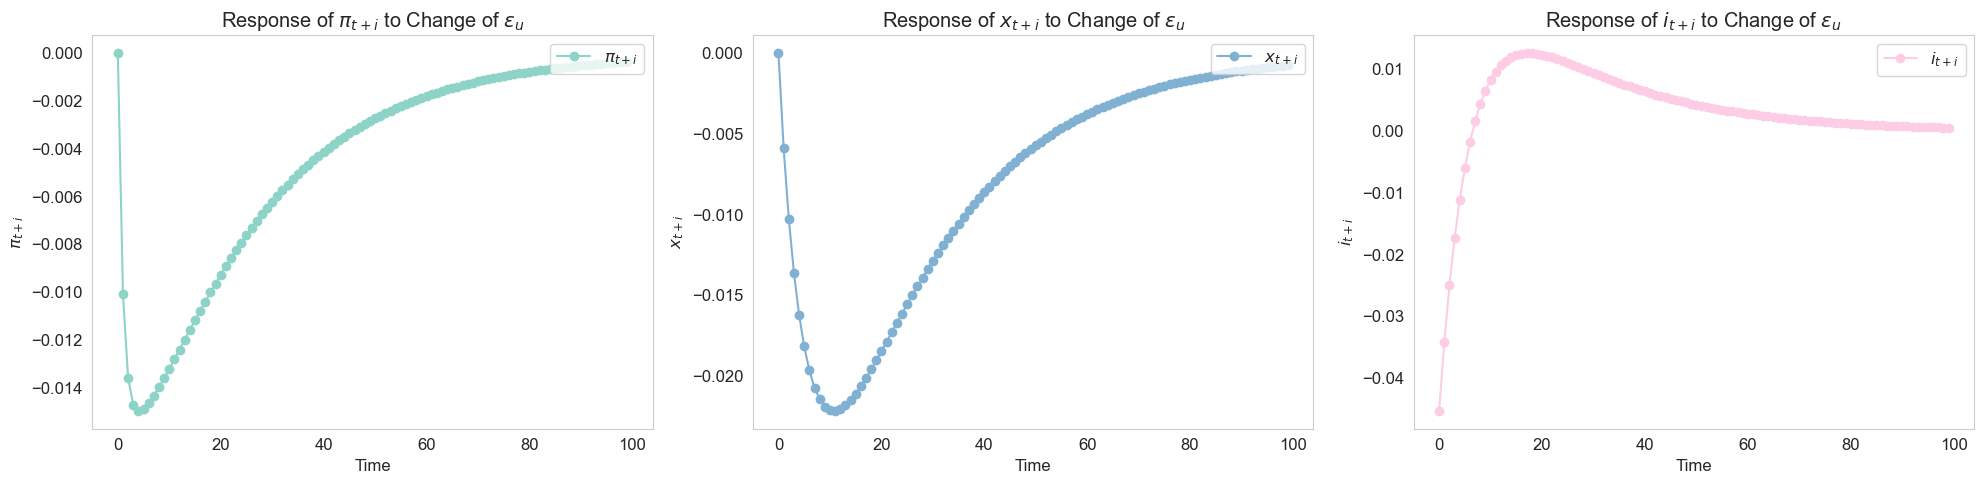

In [7]:
cost_push_irf = simulate_irf(A, B, F, 'cost_push', shock_size=0.01)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
labels = [r'$\pi_{t+i}$', r'$x_{t+i}$', r'$i_{t+i}$']
shocks_name = r'$ε_{u}$'

color_name = 'Set3' 
select2 = (0.05,0.35,0.60)
colors_2 = plt.get_cmap(color_name)(select2)

for i in range(3):
    axes[i].plot(range(len(cost_push_irf)), cost_push_irf.iloc[:, i], marker='o', linestyle='-', color=colors_2[i], label=labels[i])
    axes[i].set_title(f'Response of {labels[i]} to Change of {shocks_name}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(labels[i])
    axes[i].grid()
    axes[i].legend(loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(result_dir, f'response_cost_push.png'), dpi=300)
plt.show()


### Q3

In [8]:
def parameter_sensitivity_analysis():
    # Define parameter ranges to test
    sigma_range = np.linspace(1, 10, 10)
    rho_u_range = np.linspace(0.01, 0.99, 9)
    rho_r_range = np.linspace(0.01, 0.99, 9)
    lambda_x_range = np.linspace(0.01, 0.2, 10)
    lambda_i_range = np.linspace(0.01, 0.5, 10)
    results = {
        'sigma': {'range': sigma_range, 'phi_pi': [], 'phi_x': [], 'phi_0': []},
        'rho_u': {'range': rho_u_range, 'phi_pi': [], 'phi_x': [], 'phi_0': []},
        'rho_r': {'range': rho_r_range, 'phi_pi': [], 'phi_x': [], 'phi_0': []},
        'lambda_x': {'range': lambda_x_range, 'phi_pi': [], 'phi_x': [], 'phi_0': []},
        'lambda_i': {'range': lambda_i_range, 'phi_pi': [], 'phi_x': [], 'phi_0': []}
    }

    # Vary sigma
    for sig in sigma_range:
        # Redefine matrices with new sigma
        A_tmp = np.array([
            [1, 0, 0, 0, 0],
            [-kappa/beta, 1/beta, -kappa/beta, -1/beta, 0],
            [sig*(kappa/beta + 1), -sig/beta, sig*beta+1, sig/beta, -sig],
            [0, 0, 0, rho_u, 0],
            [0, 0, 0, 0, rho_r]
        ])

        B_tmp = np.array([
            [0],
            [0],
            [sig],
            [0],
            [0]
        ])

        # Solve optimal policy
        lq_tmp = LQ(Q, R, A_tmp, B_tmp, beta=beta)
        P_tmp, F_tmp, d_tmp = lq_tmp.stationary_values()

        # Calculate Taylor rule coefficients
        phi_pi_tmp = -F_tmp[0, 1]
        phi_x_tmp = -F_tmp[0, 2]
        phi_0_tmp = -F_tmp[0, 0]  

        # Store results
        results['sigma']['phi_pi'].append(phi_pi_tmp)
        results['sigma']['phi_x'].append(phi_x_tmp)
        results['sigma']['phi_0'].append(phi_0_tmp)  

    # Vary rho_u
    for ru in rho_u_range:
        # Redefine matrices with new rho_u
        A_tmp = np.array([
            [1, 0, 0, 0, 0],
            [-kappa/beta, 1/beta, -kappa/beta, -1/beta, 0],
            [sigma*(kappa/beta + 1), -sigma/beta, sigma*beta+1, sigma/beta, -sigma],
            [0, 0, 0, ru, 0],
            [0, 0, 0, 0, rho_r]
        ])
        B_tmp = np.array([
            [0],
            [0],
            [sigma],
            [0],
            [0]
        ])

        # Solve optimal policy
        lq_tmp = LQ(Q, R, A_tmp, B_tmp, beta=beta)
        P_tmp, F_tmp, d_tmp = lq_tmp.stationary_values()

        # Calculate Taylor rule coefficients
        phi_pi_tmp = -F_tmp[0, 1]
        phi_x_tmp = -F_tmp[0, 2]
        phi_0_tmp = -F_tmp[0, 0]  

        # Store results
        results['rho_u']['phi_pi'].append(phi_pi_tmp)
        results['rho_u']['phi_x'].append(phi_x_tmp)
        results['rho_u']['phi_0'].append(phi_0_tmp)  

    # Vary rho_r
    for rr in rho_r_range:
        # Redefine matrices with new rho_r
        A_tmp = np.array([
            [1, 0, 0, 0, 0],
            [-kappa/beta, 1/beta, -kappa/beta, -1/beta, 0],
            [sigma*(kappa/beta + 1), -sigma/beta, sigma*beta+1, sigma/beta, -sigma],
            [0, 0, 0, rho_u, 0],
            [0, 0, 0, 0, rr]
        ])

        # Solve optimal policy
        lq_tmp = LQ(Q, R, A_tmp, B_tmp, beta=beta)
        P_tmp, F_tmp, d_tmp = lq_tmp.stationary_values()

        # Calculate Taylor rule coefficients
        phi_pi_tmp = -F_tmp[0, 1]
        phi_x_tmp = -F_tmp[0, 2]
        phi_0_tmp = -F_tmp[0, 0]  

        # Store results
        results['rho_r']['phi_pi'].append(phi_pi_tmp)
        results['rho_r']['phi_x'].append(phi_x_tmp)
        results['rho_r']['phi_0'].append(phi_0_tmp)  

    # Vary lambda_x
    for lx in lambda_x_range:
        # Redefine R matrix with new lambda_x
        R_tmp = np.array([
            [0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0],
            [0, 0, lx, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0]
        ])

        # Solve optimal policy
        lq_tmp = LQ(Q, R_tmp, A, B, beta=beta)
        P_tmp, F_tmp, d_tmp = lq_tmp.stationary_values()

        # Calculate Taylor rule coefficients
        phi_pi_tmp = -F_tmp[0, 1]
        phi_x_tmp = -F_tmp[0, 2]
        phi_0_tmp = -F_tmp[0, 0]  
        # Store results
        results['lambda_x']['phi_pi'].append(phi_pi_tmp)
        results['lambda_x']['phi_x'].append(phi_x_tmp)
        results['lambda_x']['phi_0'].append(phi_0_tmp) 

    # Vary lambda_i
    for li in lambda_i_range:
        # Redefine Q matrix with new lambda_i
        Q_tmp = np.array([[li]])

        # Solve optimal policy
        lq_tmp = LQ(Q_tmp, R, A, B, beta=beta)
        P_tmp, F_tmp, d_tmp = lq_tmp.stationary_values()

        # Calculate Taylor rule coefficients
        phi_pi_tmp = -F_tmp[0, 1]
        phi_x_tmp = -F_tmp[0, 2]
        phi_0_tmp = -F_tmp[0, 0]  

        # Store results
        results['lambda_i']['phi_pi'].append(phi_pi_tmp)
        results['lambda_i']['phi_x'].append(phi_x_tmp)
        results['lambda_i']['phi_0'].append(phi_0_tmp)  

    return results

In [9]:
sensitivity_results = parameter_sensitivity_analysis()

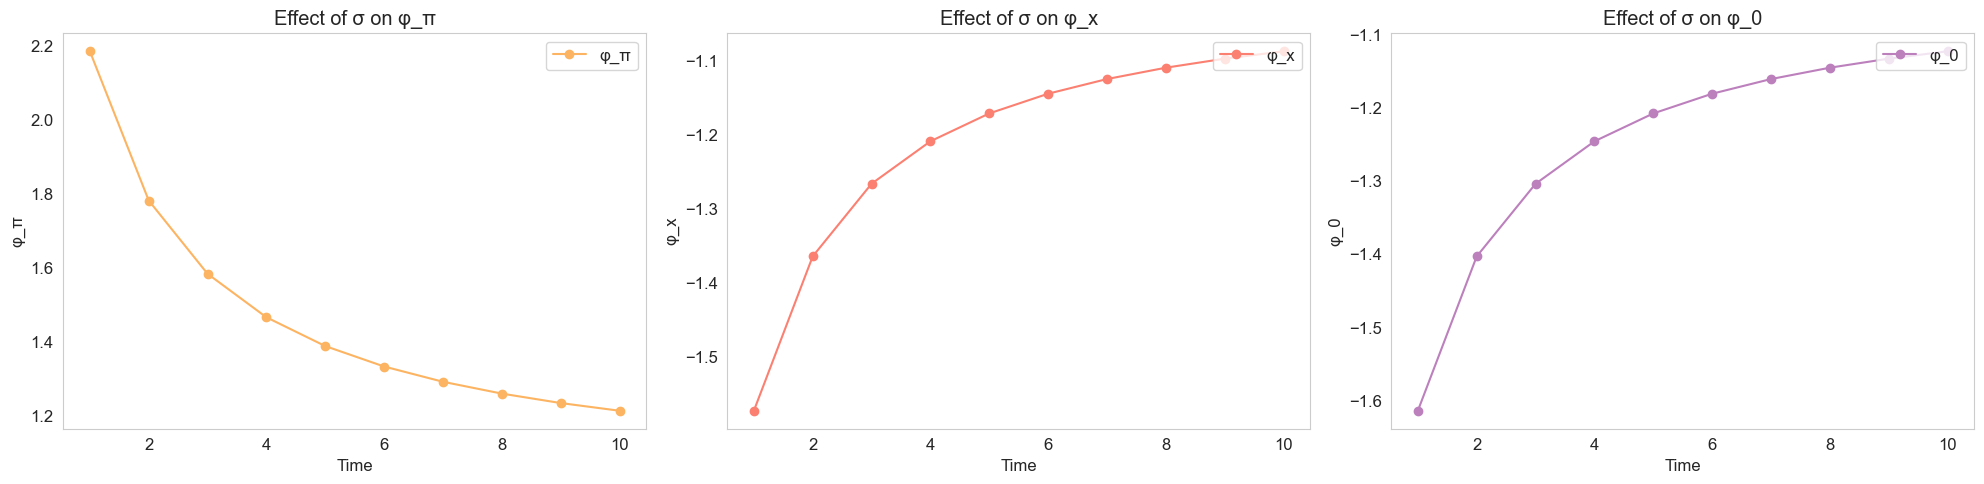

In [10]:
sensitivity_results_sigma = pd.DataFrame(sensitivity_results['sigma'])
sensitivity_results_sigma = sensitivity_results_sigma.set_index('range')

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
labels = ['φ_π', 'φ_x', 'φ_0']
shocks_name = 'σ'

color_name = 'Set3' 
select1 = (0.45,0.3,0.8)
colors_1 = plt.get_cmap(color_name)(select1)

for i in range(3):
    axes[i].plot(sensitivity_results_sigma.index, sensitivity_results_sigma.iloc[:, i], marker='o', linestyle='-', color=colors_1[i], label=labels[i])
    axes[i].set_title(f'Effect of {shocks_name} on {labels[i]}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(labels[i])
    axes[i].grid()
    axes[i].legend(loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(result_dir, f'Effect_of_sigma.png'), dpi=300)
plt.show()

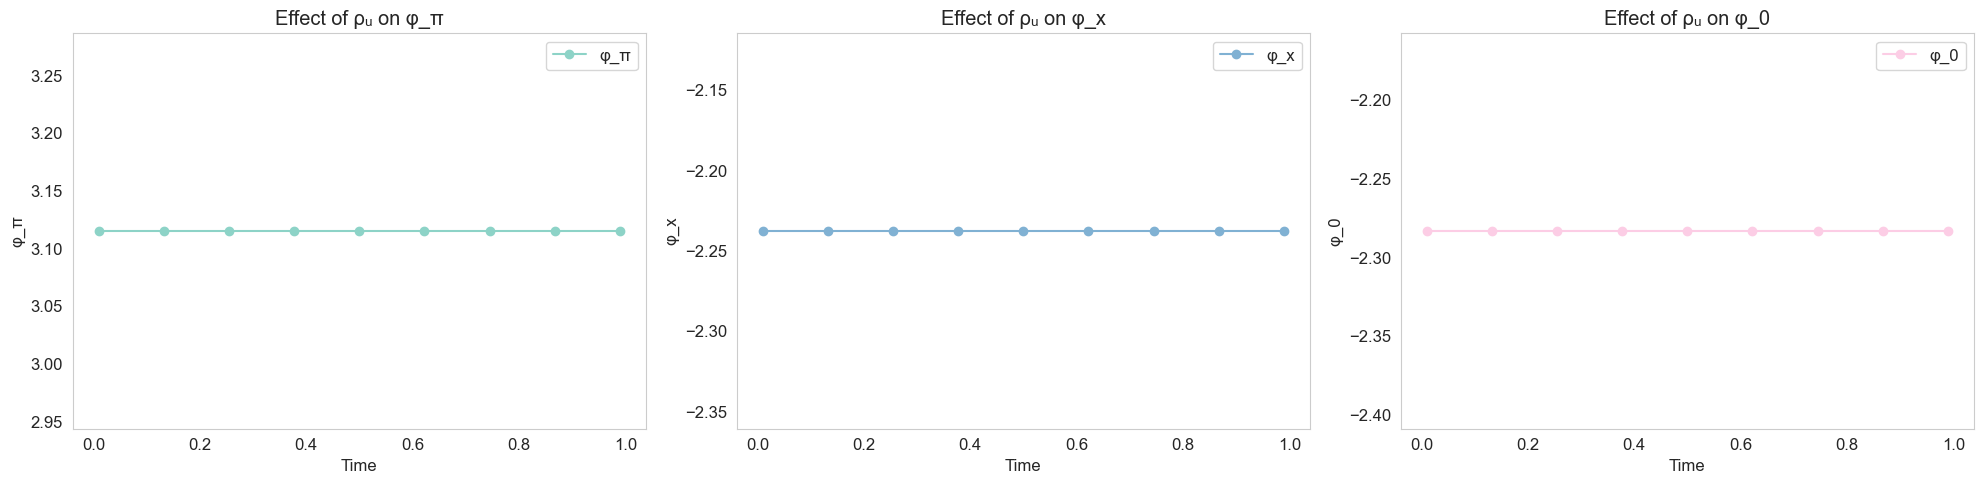

In [11]:
sensitivity_results_rho_u = pd.DataFrame(sensitivity_results['rho_u'])
sensitivity_results_rho_u = sensitivity_results_rho_u.set_index('range')

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
labels = ['φ_π', 'φ_x', 'φ_0']
shocks_name = 'ρᵤ'

color_name = 'Set3' 
select2 = (0.05,0.35,0.60)
colors_2 = plt.get_cmap(color_name)(select2)

for i in range(3):
    axes[i].plot(sensitivity_results_rho_u.index, sensitivity_results_rho_u.iloc[:, i], marker='o', linestyle='-', color=colors_2[i], label=labels[i])
    axes[i].set_title(f'Effect of {shocks_name} on {labels[i]}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(labels[i])
    axes[i].grid()
    axes[i].legend(loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(result_dir, f'Effect_of_rho_u.png'), dpi=300)
plt.show()

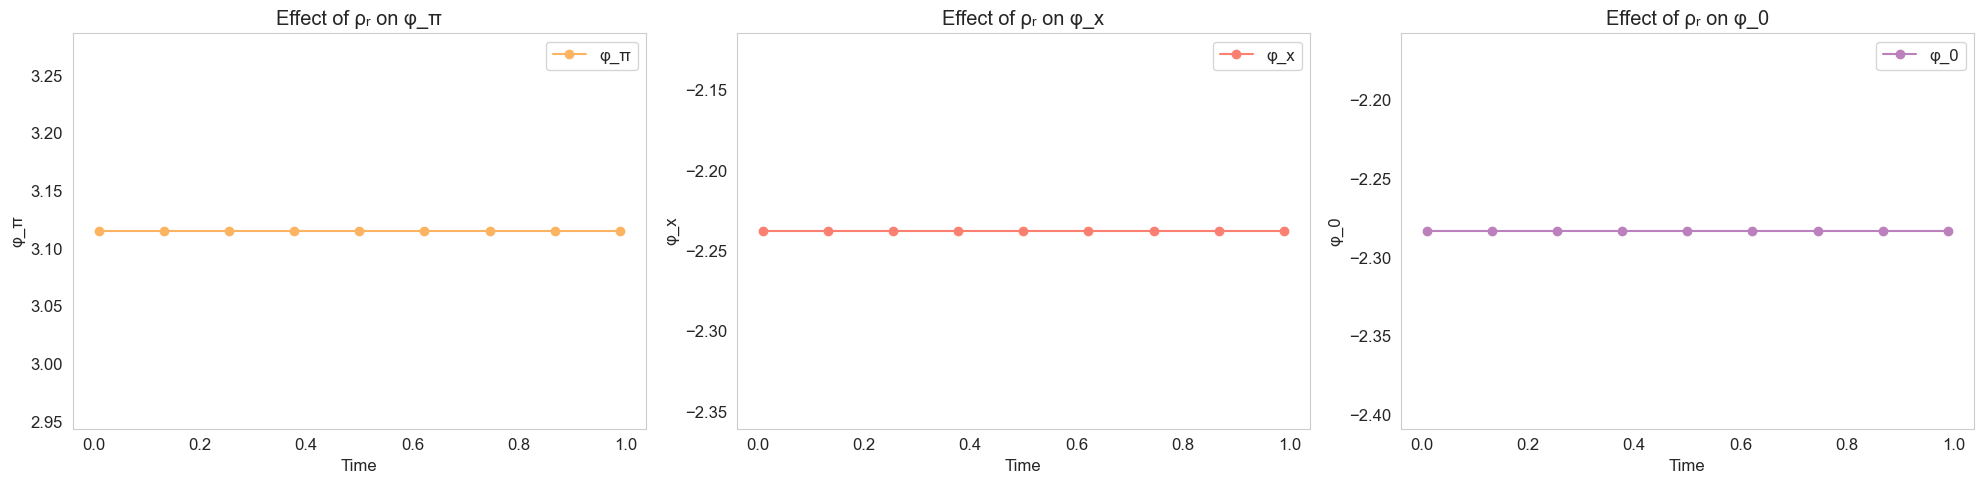

In [12]:
sensitivity_results_rho_r = pd.DataFrame(sensitivity_results['rho_r'])
sensitivity_results_rho_r = sensitivity_results_rho_r.set_index('range')

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
labels = ['φ_π', 'φ_x', 'φ_0']
shocks_name = 'ρᵣ'

color_name = 'Set3' 
select1 = (0.45,0.3,0.8)
colors_1 = plt.get_cmap(color_name)(select1)

for i in range(3):
    axes[i].plot(sensitivity_results_rho_r.index, sensitivity_results_rho_r.iloc[:, i], marker='o', linestyle='-', color=colors_1[i], label=labels[i])
    axes[i].set_title(f'Effect of {shocks_name} on {labels[i]}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(labels[i])
    axes[i].grid()
    axes[i].legend(loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(result_dir, f'Effect_of_rho_r.png'), dpi=300)
plt.show()

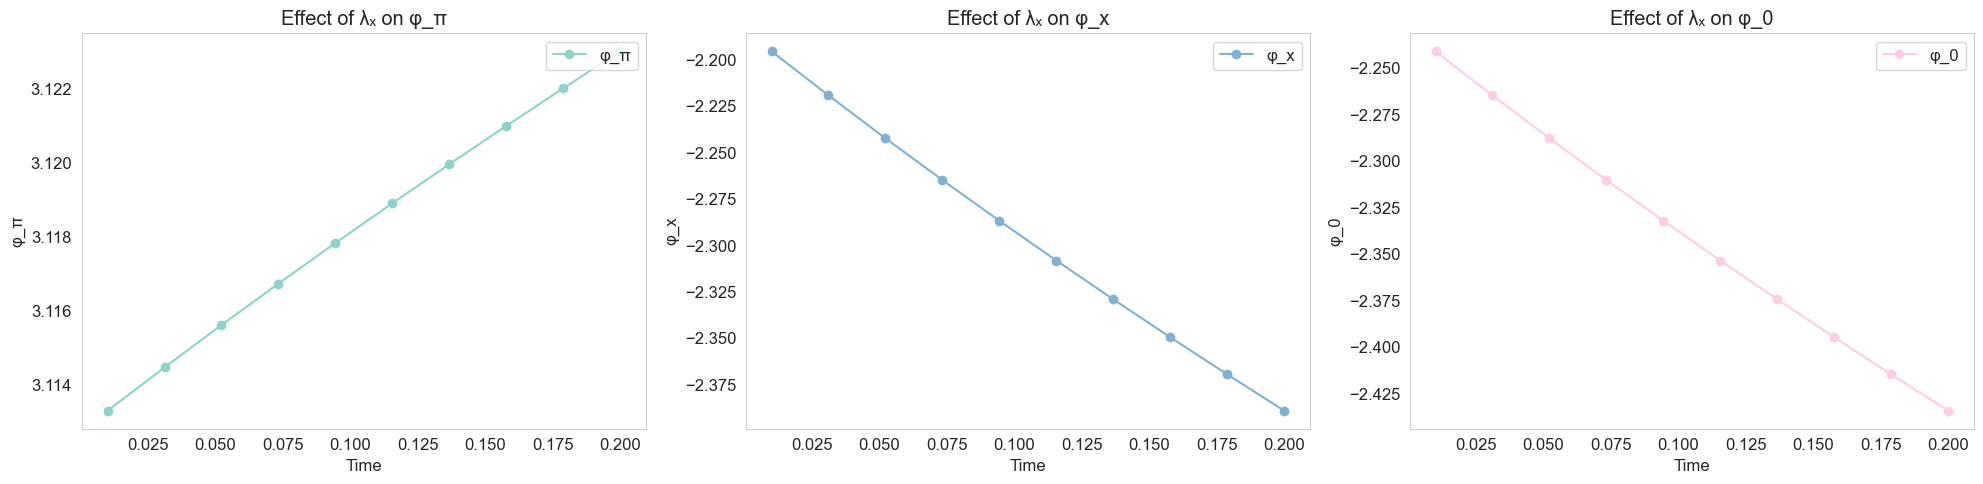

In [13]:
sensitivity_results_lambda_x = pd.DataFrame(sensitivity_results['lambda_x'])
sensitivity_results_lambda_x = sensitivity_results_lambda_x.set_index('range')

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
labels = ['φ_π', 'φ_x', 'φ_0']
shocks_name = 'λₓ'

color_name = 'Set3' 
select2 = (0.05,0.35,0.60)
colors_2 = plt.get_cmap(color_name)(select2)

for i in range(3):
    axes[i].plot(sensitivity_results_lambda_x.index, sensitivity_results_lambda_x.iloc[:, i], marker='o', linestyle='-', color=colors_2[i], label=labels[i])
    axes[i].set_title(f'Effect of {shocks_name} on {labels[i]}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(labels[i])
    axes[i].grid()
    axes[i].legend(loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(result_dir, f'Effect_of_lambda_x.png'), dpi=300)
plt.show()

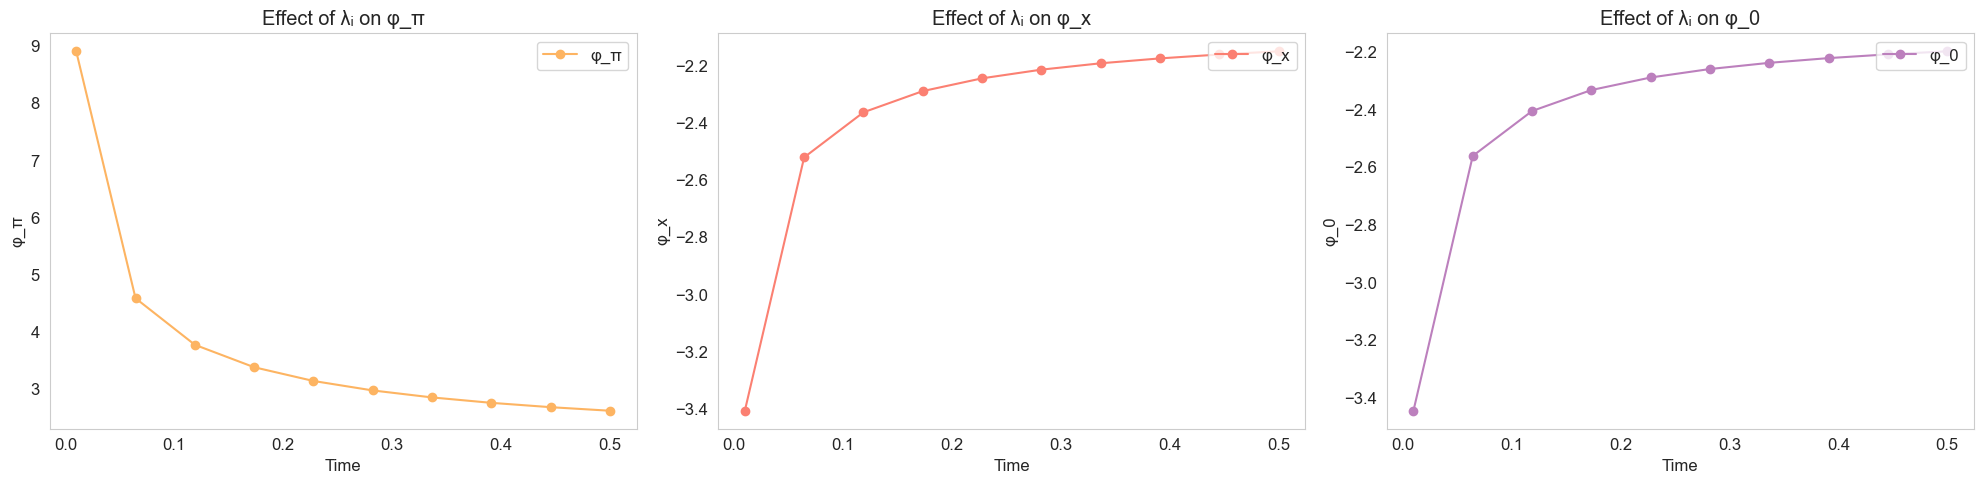

In [14]:
sensitivity_results_lambda_i = pd.DataFrame(sensitivity_results['lambda_i'])
sensitivity_results_lambda_i = sensitivity_results_lambda_i.set_index('range')

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
labels = ['φ_π', 'φ_x', 'φ_0']
shocks_name = 'λᵢ'

color_name = 'Set3' 
select1 = (0.45,0.3,0.8)
colors_1 = plt.get_cmap(color_name)(select1)

for i in range(3):
    axes[i].plot(sensitivity_results_lambda_i.index, sensitivity_results_lambda_i.iloc[:, i], marker='o', linestyle='-', color=colors_1[i], label=labels[i])
    axes[i].set_title(f'Effect of {shocks_name} on {labels[i]}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(labels[i])
    axes[i].grid()
    axes[i].legend(loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(result_dir, f'Effect_of_lambda_i.png'), dpi=300)
plt.show()